<h1>Lending Club Case Study</h1>

In [475]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

<h2>1. Data Cleaning and Manipulation</h2>

In [476]:
# Read the Excel file into a DataFrame
raw_data = pd.read_csv("loan.csv")
raw_data.shape

(39717, 111)

<b>Drop Columns that has all null</b>

In [477]:
columns = raw_data.isna().sum()
nullcolumns = columns[columns == 39717].index.tolist()
#print("List of Null Columns ", nullcolumns)
print("Number of Null columns dropped", len(nullcolumns))
raw_data = raw_data.drop(nullcolumns, axis=1)
raw_data.shape

Number of Null columns dropped 54


(39717, 57)

<b>Drop Columns that has same value across all rows</b>

In [478]:
dupcolumns = [column for column in raw_data.columns if raw_data[column].nunique()==1]
#print("List of Duplicate Columns ", dupcolumns)
print("Number of duplicate columns dropped", len(dupcolumns))
raw_data = raw_data.drop(dupcolumns, axis=1)
raw_data.shape

Number of duplicate columns dropped 9


(39717, 48)

<b>Remove other columns which is not relevant for the analysis</b>

In [479]:
raw_data = raw_data.drop(["id", "member_id","funded_amnt", "funded_amnt_inv", "emp_title", "url", "desc", "title", "next_pymnt_d", "last_pymnt_d"], axis=1)
raw_data.shape

(39717, 38)

<b>Impute Values</b>

In [480]:
# Fill all 'NA' values
raw_data['mths_since_last_delinq'] = raw_data['mths_since_last_delinq'].fillna(0)
raw_data['emp_length'] = raw_data['emp_length'].fillna(0)
raw_data['pub_rec_bankruptcies'] = raw_data['pub_rec_bankruptcies'].fillna(0)
raw_data['mths_since_last_record'] = raw_data['mths_since_last_record'].fillna(0)
raw_data['revol_util'] = raw_data['revol_util'].fillna(0)

# Replace values in few columns and change type from object to int/float64
raw_data['term'] = raw_data['term'].str.replace(' months', '')
raw_data['term'] = raw_data['term'].astype('int64')
raw_data['int_rate'] = raw_data['int_rate'].str.replace('%', '')
raw_data['int_rate'] = raw_data['int_rate'].astype('float64')
raw_data['revol_util'] = raw_data['revol_util'].str.replace('%', '')
raw_data['revol_util'] = raw_data['revol_util'].astype('float64')
raw_data['emp_length'] = raw_data['emp_length'].str.replace('10\+ years', '10')
raw_data['emp_length'] = raw_data['emp_length'].str.replace(' years', '')
raw_data['emp_length'] = raw_data['emp_length'].str.replace(' year', '')
raw_data['emp_length'] = raw_data['emp_length'].str.replace('< 1', '0.5')
raw_data['emp_length'] = raw_data['emp_length'].astype('float64')
raw_data['emp_length'] = raw_data['emp_length'].fillna(0)
raw_data = raw_data.rename(columns={'term': 'term_in_months', 'revol_util': 'revol_util_in_percent', 'emp_length':'years_of_exp'})
lc_analysis_data = raw_data[raw_data.loan_status != "Current"]
lc_analysis_data.shape

(38577, 38)

<h2>2. Data analysis</h2>

<h3>Univariate Analysis</h3>

In [481]:
def remove_outliers(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return data[(data >= lower_bound) & (data <= upper_bound)]

<h4> Charged Off applications increase for larger loan amounts. E.g. Loan amount more than 30000 dollors
have 28.6% defaulters (Amongst Charged off + fully paid)</h4>

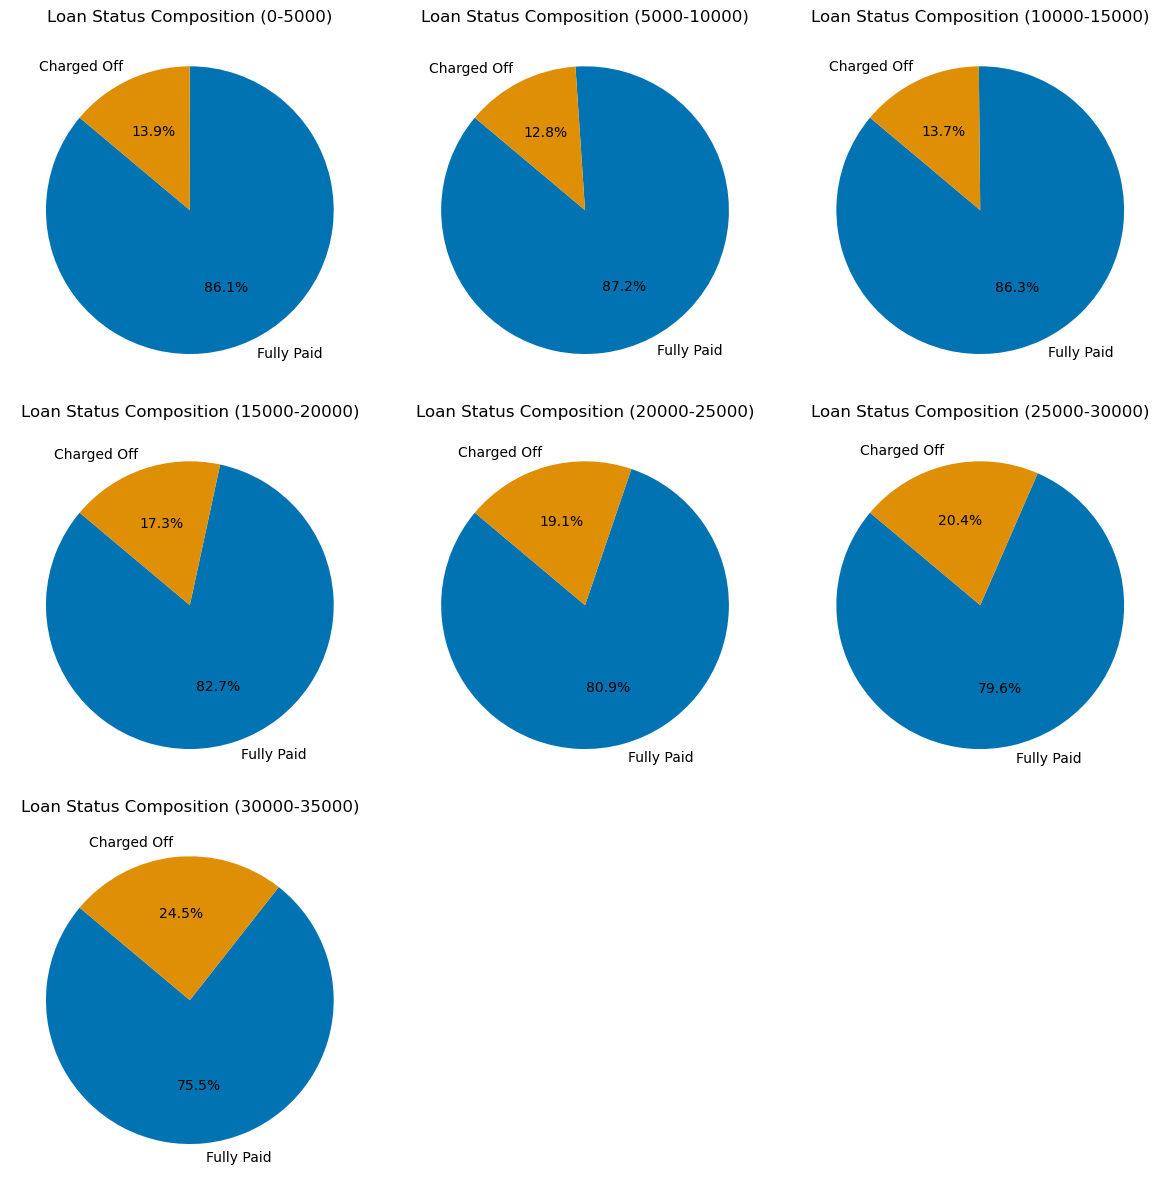

In [482]:
# Create bins for 'loan_amnt' column
bin_width = 5000
bins = range(0, int(lc_analysis_data['loan_amnt'].max()) + bin_width, bin_width)

# Group the data by 'loan_amnt' using the defined bins
grouped = lc_analysis_data.groupby(pd.cut(lc_analysis_data['loan_amnt'], bins=bins))
num_bins = len(grouped)

# Calculate the number of rows and columns for the grid
num_rows = (num_bins - 1) // 3 + 1
num_cols = min(num_bins, 3)

# Create a 3x3 grid of subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 12))

# Flatten the axes array for easier indexing
axes = axes.ravel()

# Iterate through each bin and create a pie chart for 'loan_status' composition
for i, (group_name, group_data) in enumerate(grouped):
    # Calculate the composition of 'loan_status' within the current bin
    status_composition = group_data['loan_status'].value_counts(normalize=True)
    
    # Create a pie chart
    axes[i].pie(status_composition, labels=status_composition.index, autopct='%1.1f%%', startangle=140)
    
    # Set title
    axes[i].set_title(f'Loan Status Composition ({group_name.left}-{group_name.right})')

# Remove any remaining empty subplots
for i in range(num_bins, num_rows * num_cols):
    fig.delaxes(axes[i])

# Adjust spacing between subplots
plt.tight_layout()

# Display the grid of pie charts
plt.show()

<h4> Group F and G have the hightest Charged off applicants. To be specific F5 sub group have 50% charged off application </h4>

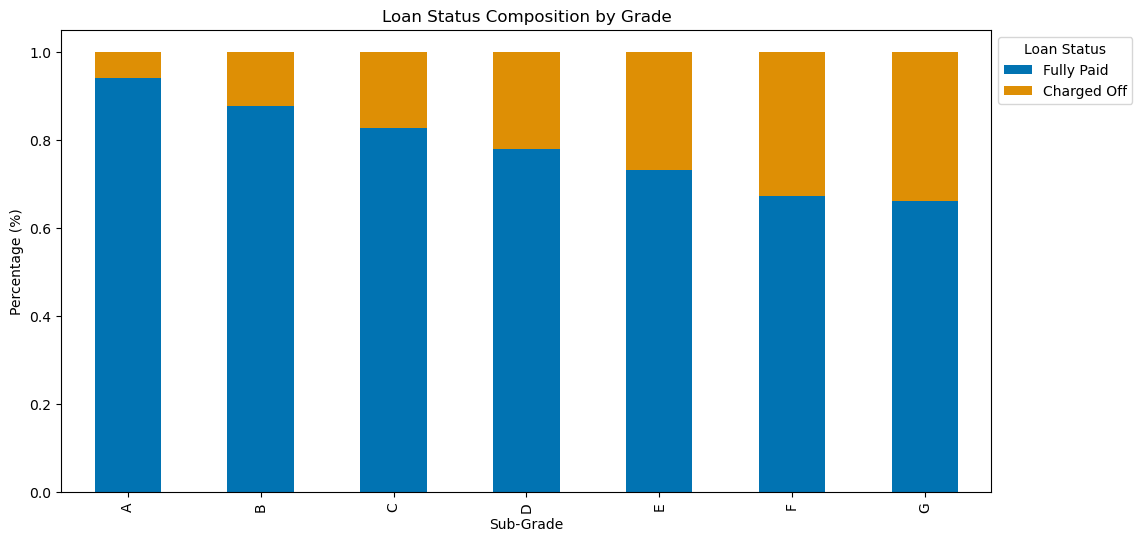

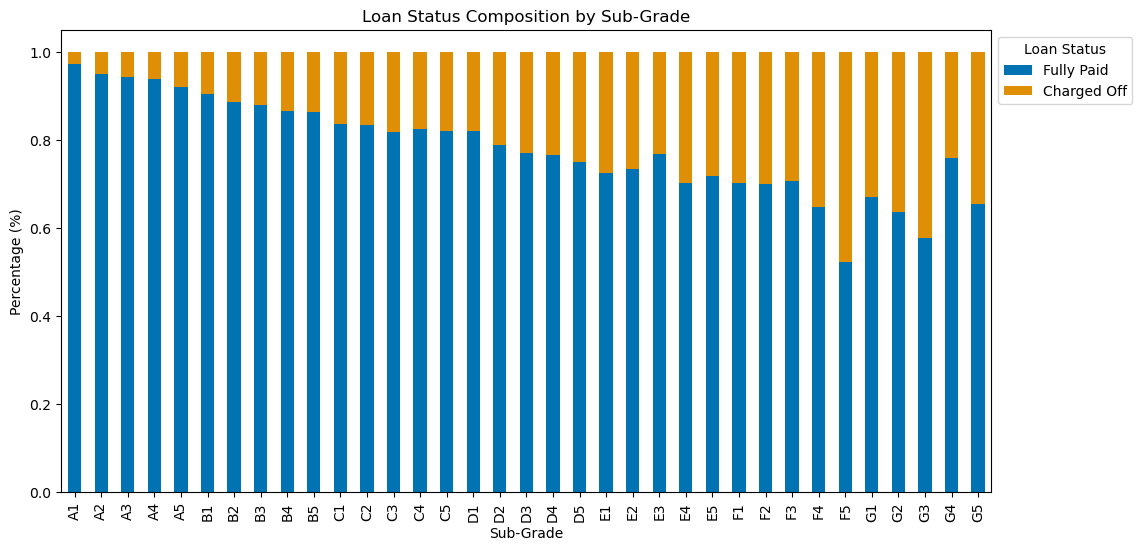

In [483]:
grouped = lc_analysis_data.groupby('grade')

# Calculate the composition of 'loan_status' for each grade
subgroup_compositions = {}
for group_name, group_data in grouped:
    status_composition = group_data['loan_status'].value_counts(normalize=True)
    subgroup_compositions[group_name] = status_composition

# Create a DataFrame from the compositions
composition_df = pd.DataFrame(subgroup_compositions).T.fillna(0)

# Plotting a bar chart for the composition
composition_df.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title('Loan Status Composition by Grade')
plt.xlabel('Sub-Grade')
plt.ylabel('Percentage (%)')
plt.legend(title='Loan Status', bbox_to_anchor=(1, 1))

# Show the plot
plt.show()
grouped = lc_analysis_data.groupby('sub_grade')

# Calculate the composition of 'loan_status' for each subgroup
subgroup_compositions = {}
for group_name, group_data in grouped:
    status_composition = group_data['loan_status'].value_counts(normalize=True)
    subgroup_compositions[group_name] = status_composition

# Create a DataFrame from the compositions
composition_df = pd.DataFrame(subgroup_compositions).T.fillna(0)

# Plotting a bar chart for the composition
composition_df.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title('Loan Status Composition by Sub-Grade')
plt.xlabel('Sub-Grade')
plt.ylabel('Percentage (%)')
plt.legend(title='Loan Status', bbox_to_anchor=(1, 1))

# Show the plot
plt.show()

<h4> Small Business loan type are the highest to Charge off and marriage loan type are safest. May be consider to revise interest rate of small business</h4>

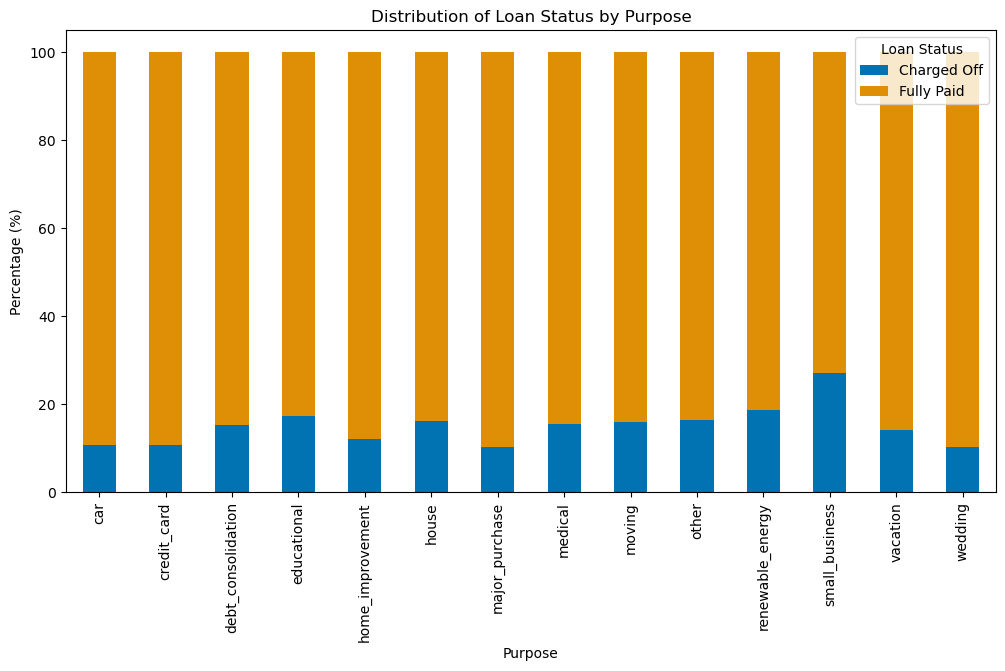

In [484]:
grouped = lc_analysis_data.groupby(['purpose', 'loan_status']).size().unstack(fill_value=0)

# Calculate the total count of each 'purpose' group
total_counts = grouped.sum(axis=1)

# Calculate the percentage distribution for each 'purpose' group
percentage_distribution = (grouped.T / total_counts * 100).T

percentage_distribution.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title('Distribution of Loan Status by Purpose')
plt.xlabel('Purpose')
plt.ylabel('Percentage (%)')
plt.legend(title='Loan Status')

# Show the plot
plt.show()

<h4> Loans with less interest rate i.e. less than 11.26% have higher probablity of getting fully payed back  </h4>

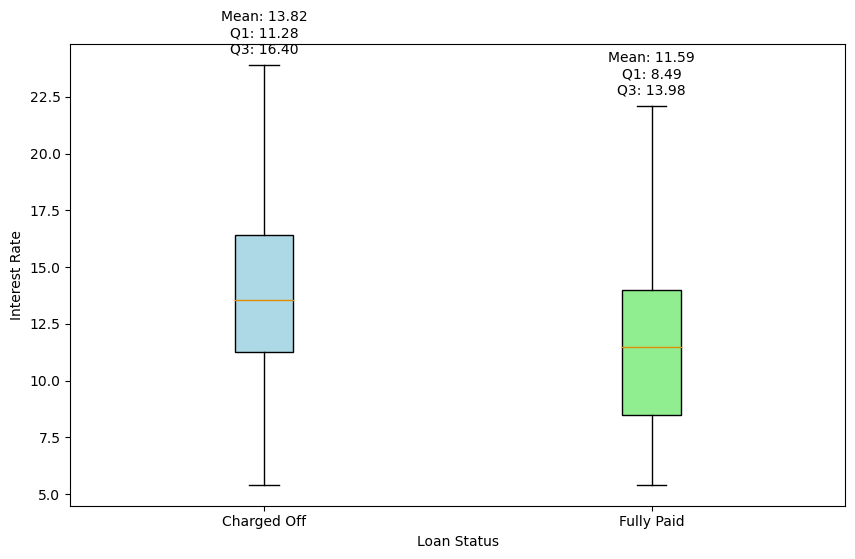

In [485]:
# Group the data by 'loan_status'
grouped = lc_analysis_data.groupby('loan_status')

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Create a list to store cleaned data for each 'loan_status' group
cleaned_data_to_plot = []

# Create a list to store statistical values for each group
statistical_values = []

# Iterate through each 'loan_status' group, remove outliers, and store cleaned data and statistics
for _, group in grouped:
    cleaned_data = remove_outliers(group['int_rate'])
    cleaned_data_to_plot.append(cleaned_data)
    
    mean_value = cleaned_data.mean()
    Q1 = cleaned_data.quantile(0.25)
    Q3 = cleaned_data.quantile(0.75)
    
    stats_text = f'Mean: {mean_value:.2f}\nQ1: {Q1:.2f}\nQ3: {Q3:.2f}'
    statistical_values.append(stats_text)

# Create a box plot for the cleaned data on the same plot
box_plot = ax.boxplot(cleaned_data_to_plot, vert=True, patch_artist=True, labels=grouped.groups.keys())

# Add labels and title
ax.set_xlabel('Loan Status')
ax.set_ylabel('Interest Rate')

# Set colors for the box plots
colors = ['lightblue', 'lightgreen', 'lightcoral']
for patch, color in zip(box_plot['boxes'], colors):
    patch.set_facecolor(color)

# Add statistical values as text to the plot
for i, stats in enumerate(statistical_values):
    ax.text(i + 1, max(cleaned_data_to_plot[i]) + 0.5, stats, horizontalalignment='center', fontsize=10)

# Display the plot
plt.show()

<h4>  Derogaroty Clients and those with Public record of bankruptcies have higher probablity to default.</h4>

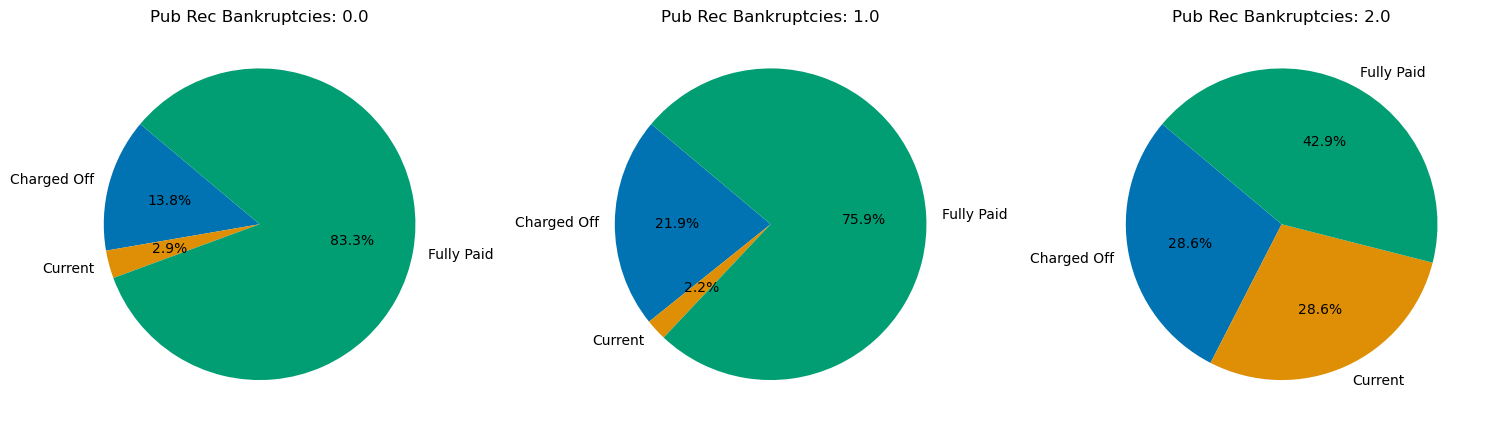

In [486]:
grouped = raw_data.groupby(['pub_rec_bankruptcies', 'loan_status']).size().unstack(fill_value=0)

# Create a figure with three subplots in one row
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Loop through each 'pub_rec_bankruptcies' group and create a pie chart
for i, (pub_rec, distribution) in enumerate(grouped.iterrows()):
    ax = axes[i]
    
    # Create a pie chart for the distribution of 'loan_status'
    ax.pie(distribution, labels=distribution.index, autopct='%1.1f%%', startangle=140)
    
    # Set title
    ax.set_title(f'Pub Rec Bankruptcies: {pub_rec}')
    
# Adjust spacing between subplots
plt.tight_layout()

# Display the subplots
plt.show()

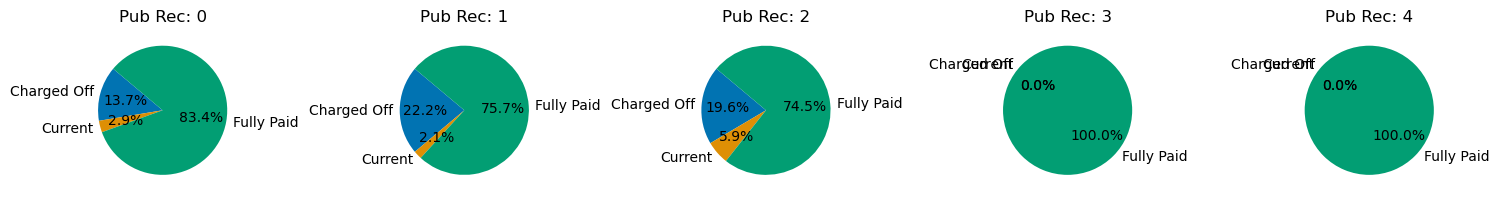

In [487]:
grouped = raw_data.groupby(['pub_rec', 'loan_status']).size().unstack(fill_value=0)

# Create a figure with three subplots in one row
fig, axes = plt.subplots(1, 5, figsize=(15, 5))

# Loop through each 'pub_rec_bankruptcies' group and create a pie chart
for i, (pub_rec, distribution) in enumerate(grouped.iterrows()):
    ax = axes[i]
    
    # Create a pie chart for the distribution of 'loan_status'
    ax.pie(distribution, labels=distribution.index, autopct='%1.1f%%', startangle=140)
    
    # Set title
    ax.set_title(f'Pub Rec: {pub_rec}')
    
# Adjust spacing between subplots
plt.tight_layout()

# Display the subplots
plt.show()

<h3>Multivariate Analysis</h3>

In [488]:
lc_analysis_data_default = lc_analysis_data[lc_analysis_data.loan_status == "Charged Off"]
lc_analysis_data_default.columns

Index(['loan_amnt', 'term_in_months', 'int_rate', 'installment', 'grade',
       'sub_grade', 'years_of_exp', 'home_ownership', 'annual_inc',
       'verification_status', 'issue_d', 'loan_status', 'purpose', 'zip_code',
       'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line',
       'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record',
       'open_acc', 'pub_rec', 'revol_bal', 'revol_util_in_percent',
       'total_acc', 'out_prncp', 'out_prncp_inv', 'total_pymnt',
       'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
       'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
       'last_pymnt_amnt', 'last_credit_pull_d', 'pub_rec_bankruptcies'],
      dtype='object')

<Axes: xlabel='loan_amnt', ylabel='int_rate'>

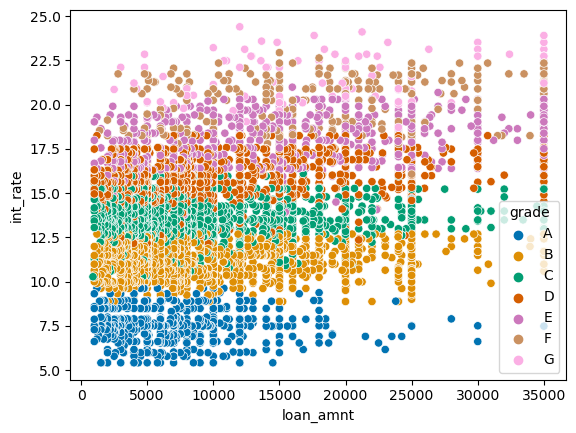

In [489]:
sns.scatterplot(x="loan_amnt",
                    y="int_rate",
                    hue="grade",
                    hue_order = ['A', 'B', 'C', 'D', 'E', 'F', 'G'],
                    data=lc_analysis_data_default)
# Observations
# Clean Segements on interest rate and grade, interest rate increase as the grade lowers
# Larger number of Higher loan amounts defaulted by low grade applicants or for loans with higher interest rates
# Risk of people who default increases with higher interest rate, higher loan amount and lower grade

<Axes: xlabel='purpose', ylabel='grade'>

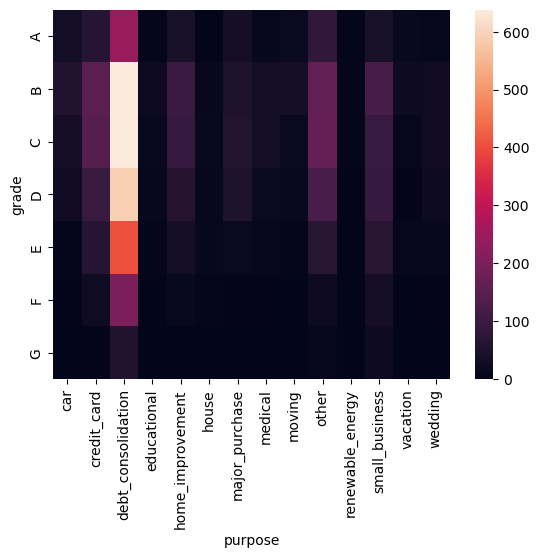

In [490]:
sns.heatmap(pd.crosstab(lc_analysis_data_default.grade, lc_analysis_data_default.purpose))
# Observations
# More borrowers across grade B,C and D, taken loan for debt consolidation has defaulted
# People who have taken loan for Credit Card, Debt Consolidation, Other and Small business are more likely to default

In [491]:
loanstatus_state_group = lc_analysis_data.groupby(['addr_state', 'loan_status']).agg({'dti': 'count'})
loanstatus_state_group['tot_num_loans'] = loanstatus_state_group.groupby('addr_state')['dti'].transform('sum')
loanstatus_state_group['chargeof_percent'] = round(100 * loanstatus_state_group['dti'] / loanstatus_state_group.groupby('addr_state')['dti'].transform('sum'), 0)
loanstatus_state_group = loanstatus_state_group.reset_index(level=['addr_state', 'loan_status'])
loanstatus_state_group = loanstatus_state_group.rename(columns={'dti': 'num_of_loans'})[loanstatus_state_group.loan_status=='Charged Off']
loanstatus_state_group = loanstatus_state_group[(loanstatus_state_group.tot_num_loans <3000) & (loanstatus_state_group.chargeof_percent < 50) & (loanstatus_state_group.chargeof_percent > 5)].sort_values(by=['chargeof_percent'], ascending=False)

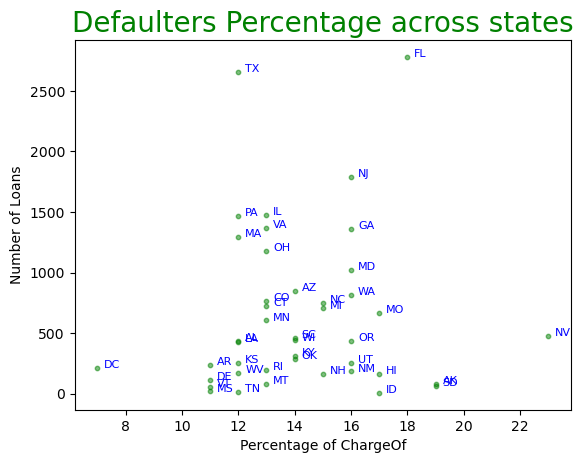

In [492]:
fig, ax = plt.subplots()
ax.scatter(x=loanstatus_state_group['chargeof_percent'],y=loanstatus_state_group['tot_num_loans'],c= 'Green', alpha= 0.5, s = 10)
ax.set_xlabel('Percentage of ChargeOf')
ax.set_ylabel('Number of Loans')

plt.title("Defaulters Percentage across states", fontdict={'fontsize': 20, 'fontweight' : 5, 'color' : 'Green'})

# annotate points in axis
for idx, row in loanstatus_state_group.iterrows():
    ax.annotate(row['addr_state'], (row['chargeof_percent'], row['tot_num_loans']), xytext=(5,0), textcoords='offset points',
                family='sans-serif', fontsize=8, color='blue')
plt.show()

# Observations
# Borrowers from the state of Florida has received more number loans and 18% of them have defaulted
# Borrowers from the state of Nevada and Nebraska has highest default percentage
# NJ and TX are the other states that has high number of defaults

In [493]:
defaultpercent_by_grade = lc_analysis_data.groupby(['grade', 'loan_status']).agg({'dti': 'count'})
defaultpercent_by_grade['tot_num_loans'] = defaultpercent_by_grade.groupby('grade')['dti'].transform('sum')
defaultpercent_by_grade['chargeof_percent'] = round(100 * defaultpercent_by_grade['dti'] / defaultpercent_by_grade.groupby('grade')['dti'].transform('sum'), 0)
defaultpercent_by_grade = defaultpercent_by_grade.reset_index(level=['grade', 'loan_status'])
defaultpercent_by_grade = defaultpercent_by_grade.rename(columns={'dti': 'num_of_loans'})[defaultpercent_by_grade.loan_status=='Charged Off'].sort_values(by=['chargeof_percent'], ascending=False)

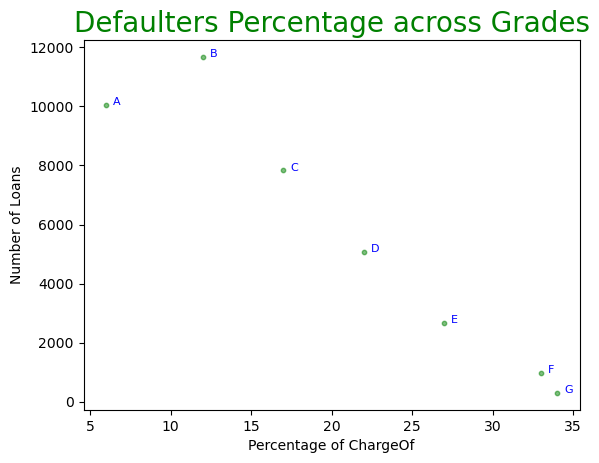

In [494]:
fig, ax = plt.subplots()
ax.scatter(x=defaultpercent_by_grade['chargeof_percent'],y=defaultpercent_by_grade['tot_num_loans'],c= 'Green', alpha= 0.5, s = 10)
ax.set_xlabel('Percentage of ChargeOf')
ax.set_ylabel('Number of Loans')

plt.title("Defaulters Percentage across Grades", fontdict={'fontsize': 20, 'fontweight' : 5, 'color' : 'Green'})

# annotate points in axis
for idx, row in defaultpercent_by_grade.iterrows():
    ax.annotate(row['grade'], (row['chargeof_percent'], row['tot_num_loans']), xytext=(5,0), textcoords='offset points',
                family='sans-serif', fontsize=8, color='blue')
plt.show()

# Observations
# Number of loans issued decreases gradually from high to low grades
# Clearly the borrowers with lower grades are more likely to default

In [495]:
defaultpercent_by_grade_purpose = lc_analysis_data.groupby(['grade', 'loan_status','purpose' ]).agg({'dti': 'count'})
defaultpercent_by_grade_purpose['tot_num_loans'] = defaultpercent_by_grade_purpose.groupby('grade')['dti'].transform('sum')
defaultpercent_by_grade_purpose['chargeof_percent'] = round(100 * defaultpercent_by_grade_purpose['dti'] / defaultpercent_by_grade_purpose.groupby('grade')['dti'].transform('sum'), 0)
defaultpercent_by_grade_purpose = defaultpercent_by_grade_purpose.reset_index(level=['grade', 'loan_status', 'purpose'])
defaultpercent_by_grade_purpose = defaultpercent_by_grade_purpose.rename(columns={'dti': 'num_of_loans'})[defaultpercent_by_grade_purpose.loan_status=='Charged Off'].sort_values(by=['chargeof_percent'], ascending=False)

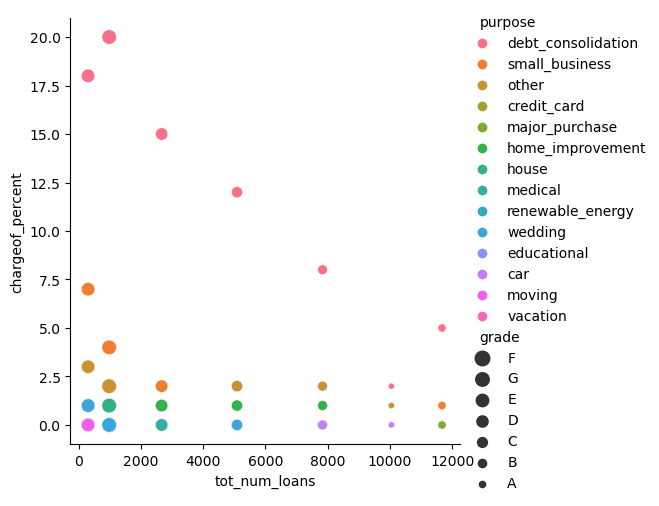

In [496]:
sns.relplot(data=defaultpercent_by_grade_purpose, x='tot_num_loans', y='chargeof_percent', size='grade', hue="purpose", sizes=(20, 110))

# Observations
# People who have taken loan for debt consolidation are more likely to default
# Lower the grade higher the default percentage for debt consolidation loans
# Small business loans taken by lower grade borrowers are more like to default next to debt consolidation

In [508]:
#lc_analysis_data[lc_analysis_data['loan_status'] == 'Charged Off'][{'mths_since_last_delinq', 'delinq_2yrs', 'total_acc','inq_last_6mths', 'dti'}].sort_values(by=['dti'], ascending=False)
dtbins = [0, 5, 10, 15, 20, 25, 30]
lc_analysis_data['dti_bin'] = pd.cut(lc_analysis_data['dti'], dtbins)

defaultpercent_by_dti = lc_analysis_data.groupby(['dti_bin', 'loan_status']).agg({'grade': 'count'})
defaultpercent_by_dti['tot_num_loans'] = defaultpercent_by_dti.groupby('dti_bin')['grade'].transform('sum')
defaultpercent_by_dti['chargeof_percent'] = round(100 * defaultpercent_by_dti['grade'] / defaultpercent_by_dti['tot_num_loans'], 0)
defaultpercent_by_dti = defaultpercent_by_dti.reset_index(level=['dti_bin', 'loan_status'])
defaultpercent_by_dti = defaultpercent_by_dti.rename(columns={'grade': 'num_of_loans'})[defaultpercent_by_dti.loan_status=='Charged Off']
defaultpercent_by_dti
#defaultpercent_by_grade_purpose

,dti_bin,loan_status,num_of_loans,tot_num_loans,chargeof_percent
0,"(0, 5]",Charged Off,597,4884,12.0
2,"(5, 10]",Charged Off,1005,7873,13.0
4,"(10, 15]",Charged Off,1402,9630,15.0
6,"(15, 20]",Charged Off,1389,8811,16.0
8,"(20, 25]",Charged Off,1118,6578,17.0
10,"(25, 30]",Charged Off,87,623,14.0


<Axes: xlabel='dti_bin', ylabel='chargeof_percent'>

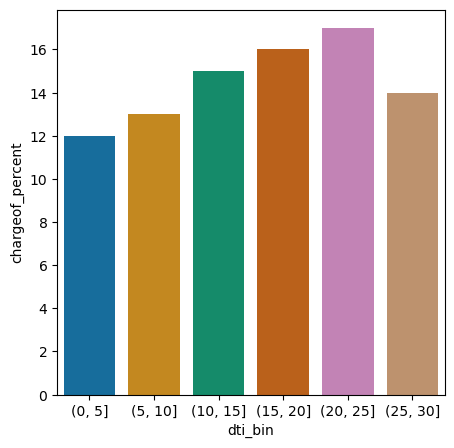

In [509]:
fig, ax = plt.subplots(figsize=(5,5))
sns.set_palette('colorblind')
sns.barplot(x = 'dti_bin', y ='chargeof_percent',
              data = defaultpercent_by_dti)

# Observations
# Risk of chargeof is higher with borrowers with higher Debt to Income ration

<Axes: xlabel='grade', ylabel='term_in_months'>

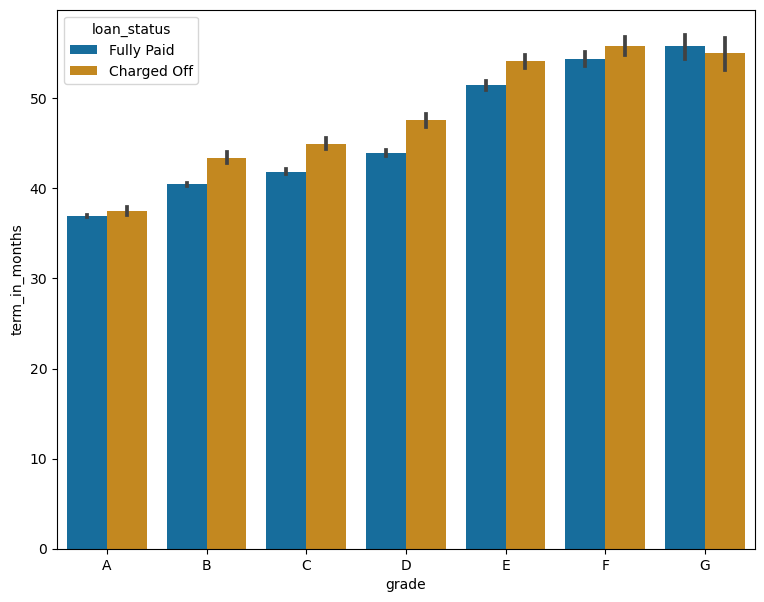

In [503]:
fig, ax = plt.subplots(figsize=(9,7))
sns.set_palette('colorblind')
sns.barplot(x = 'grade', y ='term_in_months', order = ['A', 'B', 'C', 'D', 'E', 'F', 'G'] , hue = 'loan_status',
              data = lc_analysis_data)

#Observations
#Number of terms are higher for borrowers with lower grades
#There are no significant difference in default percentage proportional to terms